# Project 2: part3

## Import libraries

In [1]:
from pymonntorch import *
import torch

import matplotlib.pyplot as plt
from simulate import Simulation
from models.activity import ActivityRecorder
from models.dendrites import Dendrite
from models.currents import ConstantCurrent, NoisyCurrent, SetCurrent, CurrentSum, RandomCurrent
from models.neurons import LIF
from models.synapses import SimpleSynapse, FullyConnectedSynapse, RandomConnectedFixedProbSynapse, RandomConnectedFixedInputSynapse
from models.time_res import TimeResolution

In [2]:
def plot_weight_distribution(weight_matrix, bins=50, density=True):
    # Flatten the weight matrix into a 1D array
    weights_flat = weight_matrix.flatten()

    # Plot the distribution using a histogram
    plt.hist(weights_flat, bins=bins, density=density, alpha=0.7, color='b')
    plt.title('Weight Matrix Distribution')
    plt.xlabel('Weight Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Part3:

### Fully connected synapse

In [3]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc = sim.add_neuron_group(
    tag="ng_exc",
    size=800,
    behavior={
        1: SetCurrent(0.0),
        2: RandomCurrent(mean=6, std=2),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_exc_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc_event")
    }
)
ng_inh = sim.add_neuron_group(
    tag="ng_inh",
    size=200,
    behavior={
        1: SetCurrent(0.0),
        2: ConstantCurrent(value=0),
        6: Dendrite(),
        7: LIF(
            tau=3,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=10,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_inh_rec"),
        10: EventRecorder(variables=['spike', "activity"], tag="ng_inh_event")
    }
)
syn_exc = sim.add_synapse_group(
                   tag="exc-exc",
                   src=ng_exc,
                   dst=ng_exc,
                   behavior={4: FullyConnectedSynapse(j0=28, variance=0.0)})
# syn_inh = net.add_synapse_group(
#                    tag="inh-inh",
#                    src=ng_inh,
#                    dst=ng_inh,
#                    behavior={4: RandomConnectedFixedInputSynapse(j0=-100, n=50, variance=0.45, alpha=0.9)})
syn_exc_inh = sim.add_synapse_group(
                   tag="exc-inh",
                   src=ng_exc,
                   dst=ng_inh,
                   behavior={4: FullyConnectedSynapse(j0=20, variance=0.3)})
syn_inh_exc = sim.add_synapse_group(
                   tag="inh-exc",
                   src=ng_inh,
                   dst=ng_exc,
                   behavior={4: FullyConnectedSynapse(j0=-100, variance=0.3)})

sim.simulate(iterations=100)

Network['Network_1', 'Network'](Neurons: tensor(1000)|2 groups, Synapses: tensor(960000)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc', 'CustomNeuronGroup', 'ng'](800){1:SetCurrent(arg_0=0.0,)2:RandomCurrent(mean=6,std=2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_event,)}
NeuronGroup['ng_inh', 'CustomNeuronGroup', 'ng'](200){1:SetCurrent(arg_0=0.0,)2:ConstantCurrent(value=0,)6:Dendrite()7:LIF(tau=3,u_rest=-65,u_reset=-70,threshold=-55,R=10,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_rec,)10:EventRecorder(variables=['spike', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_

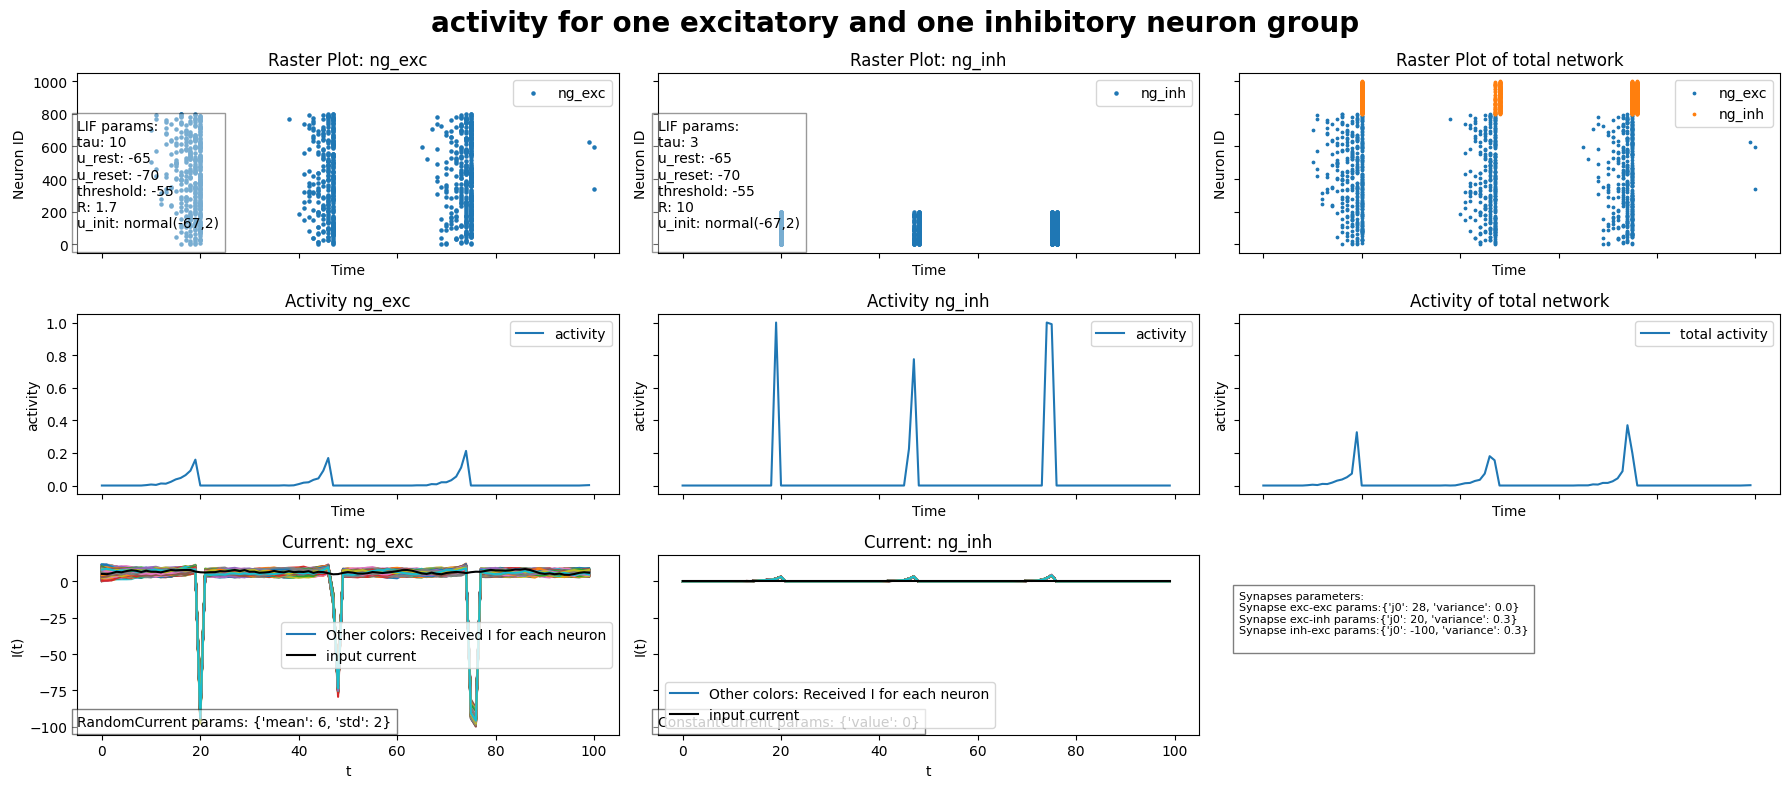

In [4]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey='row')
ng_exc.add_raster_plot(axs[0, 0])
ng_exc.add_neuron_model_params_info(axs[0, 0], model_idx=7)
ng_exc.add_activity_plot(axs[1, 0])
ng_exc.add_current_plot(axs[2, 0])
ng_exc.add_current_params_info(axs[2, 0], current_idx=2)

ng_inh.add_raster_plot(axs[0, 1])
ng_inh.add_neuron_model_params_info(axs[0, 1], model_idx=7)
ng_inh.add_activity_plot(axs[1, 1])
ng_inh.add_current_plot(axs[2, 1])
ng_inh.add_current_params_info(axs[2, 1], current_idx=2)

sim.add_raster_plot(axs[0, 2], s=3)
sim.add_activity_plot(axs[1, 2])
axs[2, 2].axis('off')
sim.add_synapses_params_info(axs[2, 2], synapse_idx=4)
plt.suptitle("activity for one excitatory and one inhibitory neuron group", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-full-synapse-80-20-rand-curr-total.pdf")
plt.show()


### Random coupling: Fixed coupling probability

In [5]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc = sim.add_neuron_group(
    tag="ng_exc",
    size=800,
    behavior={
        1: SetCurrent(0.0),
        2: RandomCurrent(mean=6, std=2),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_exc_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc_event")
    }
)
ng_inh = sim.add_neuron_group(
    tag="ng_inh",
    size=200,
    behavior={
        1: SetCurrent(0.0),
        2: ConstantCurrent(value=0),
        6: Dendrite(),
        7: LIF(
            tau=3,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=10,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_inh_rec"),
        10: EventRecorder(variables=['spike', "activity"], tag="ng_inh_event")
    }
)
syn_exc = sim.add_synapse_group(
                   tag="exc-exc",
                   src=ng_exc,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedProbSynapse(j0=28, p=0.1, variance=0.0)})
# syn_inh = net.add_synapse_group(
#                    tag="inh-inh",
#                    src=ng_inh,
#                    dst=ng_inh,
#                    behavior={4: RandomConnectedFixedInputSynapse(j0=-100, n=50, variance=0.45, alpha=0.9)})
syn_exc_inh = sim.add_synapse_group(
                   tag="exc-inh",
                   src=ng_exc,
                   dst=ng_inh,
                   behavior={4: RandomConnectedFixedProbSynapse(j0=20, p=0.4, variance=0.3)})
syn_inh_exc = sim.add_synapse_group(
                   tag="inh-exc",
                   src=ng_inh,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedProbSynapse(j0=-100, p=0.1, variance=0.3)})

sim.simulate(iterations=100)

Network['Network_1', 'Network'](Neurons: tensor(1000)|2 groups, Synapses: tensor(960000)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc', 'CustomNeuronGroup', 'ng'](800){1:SetCurrent(arg_0=0.0,)2:RandomCurrent(mean=6,std=2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_event,)}
NeuronGroup['ng_inh', 'CustomNeuronGroup', 'ng'](200){1:SetCurrent(arg_0=0.0,)2:ConstantCurrent(value=0,)6:Dendrite()7:LIF(tau=3,u_rest=-65,u_reset=-70,threshold=-55,R=10,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_rec,)10:EventRecorder(variables=['spike', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_

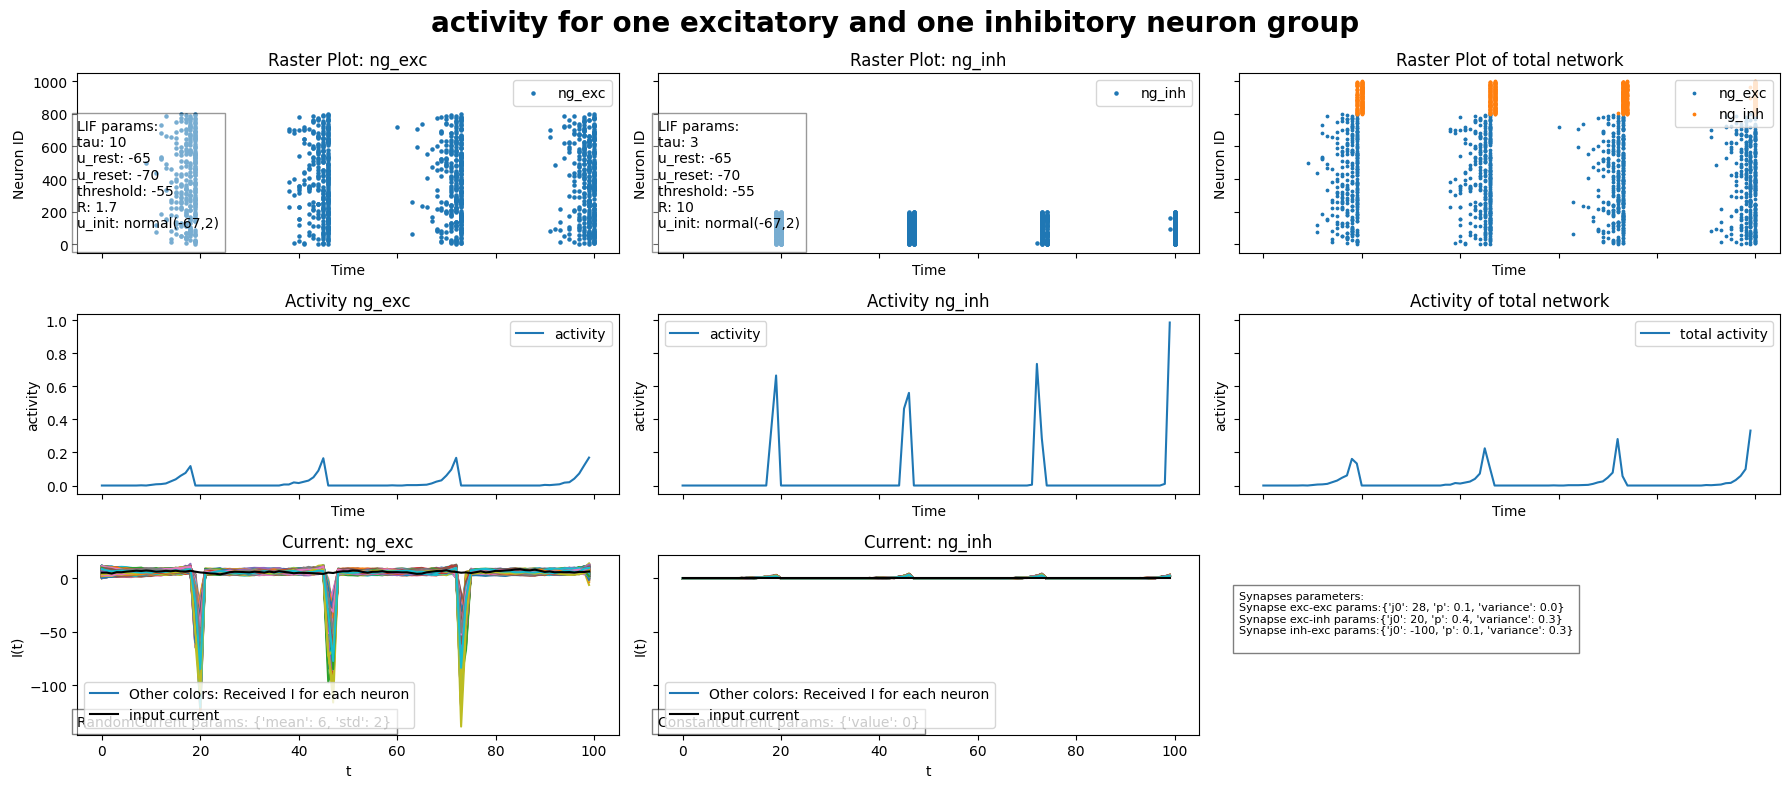

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey='row')
ng_exc.add_raster_plot(axs[0, 0])
ng_exc.add_neuron_model_params_info(axs[0, 0], model_idx=7)
ng_exc.add_activity_plot(axs[1, 0])
ng_exc.add_current_plot(axs[2, 0])
ng_exc.add_current_params_info(axs[2, 0], current_idx=2)

ng_inh.add_raster_plot(axs[0, 1])
ng_inh.add_neuron_model_params_info(axs[0, 1], model_idx=7)
ng_inh.add_activity_plot(axs[1, 1])
ng_inh.add_current_plot(axs[2, 1])
ng_inh.add_current_params_info(axs[2, 1], current_idx=2)

sim.add_raster_plot(axs[0, 2], s=3)
sim.add_activity_plot(axs[1, 2])
axs[2, 2].axis('off')
sim.add_synapses_params_info(axs[2, 2], synapse_idx=4)
plt.suptitle("activity for one excitatory and one inhibitory neuron group", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-prob-synapse-80-20-rand-curr-total.pdf")
plt.show()


### Random coupling: Fixed number of presynaptic partners

In [7]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc = sim.add_neuron_group(
    tag="ng_exc",
    size=800,
    behavior={
        1: SetCurrent(0.0),
        # 2: ConstantCurrent(value=6),
        2: RandomCurrent(mean=6, std=2),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_exc_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc_event")
    }
)
ng_inh = sim.add_neuron_group(
    tag="ng_inh",
    size=200,
    behavior={
        1: SetCurrent(0.0),
        2: ConstantCurrent(value=0),
        6: Dendrite(),
        7: LIF(
            tau=3,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=10,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_inh_rec"),
        10: EventRecorder(variables=['spike', "activity"], tag="ng_inh_event")
    }
)
syn_exc = sim.add_synapse_group(
                   tag="exc-exc",
                   src=ng_exc,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=28, n=10, variance=0.0)})
# syn_inh = net.add_synapse_group(
#                    tag="inh-inh",
#                    src=ng_inh,
#                    dst=ng_inh,
#                    behavior={4: RandomConnectedFixedInputSynapse(j0=-100, n=50, variance=0.45, alpha=0.9)})
syn_exc_inh = sim.add_synapse_group(
                   tag="exc-inh",
                   src=ng_exc,
                   dst=ng_inh,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=20, n=40, variance=0.3)})
syn_inh_exc = sim.add_synapse_group(
                   tag="inh-exc",
                   src=ng_inh,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=-100, n=15, variance=0.3)})

sim.simulate(iterations=100)

Network['Network_1', 'Network'](Neurons: tensor(1000)|2 groups, Synapses: tensor(960000)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc', 'CustomNeuronGroup', 'ng'](800){1:SetCurrent(arg_0=0.0,)2:RandomCurrent(mean=6,std=2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_event,)}
NeuronGroup['ng_inh', 'CustomNeuronGroup', 'ng'](200){1:SetCurrent(arg_0=0.0,)2:ConstantCurrent(value=0,)6:Dendrite()7:LIF(tau=3,u_rest=-65,u_reset=-70,threshold=-55,R=10,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_rec,)10:EventRecorder(variables=['spike', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_

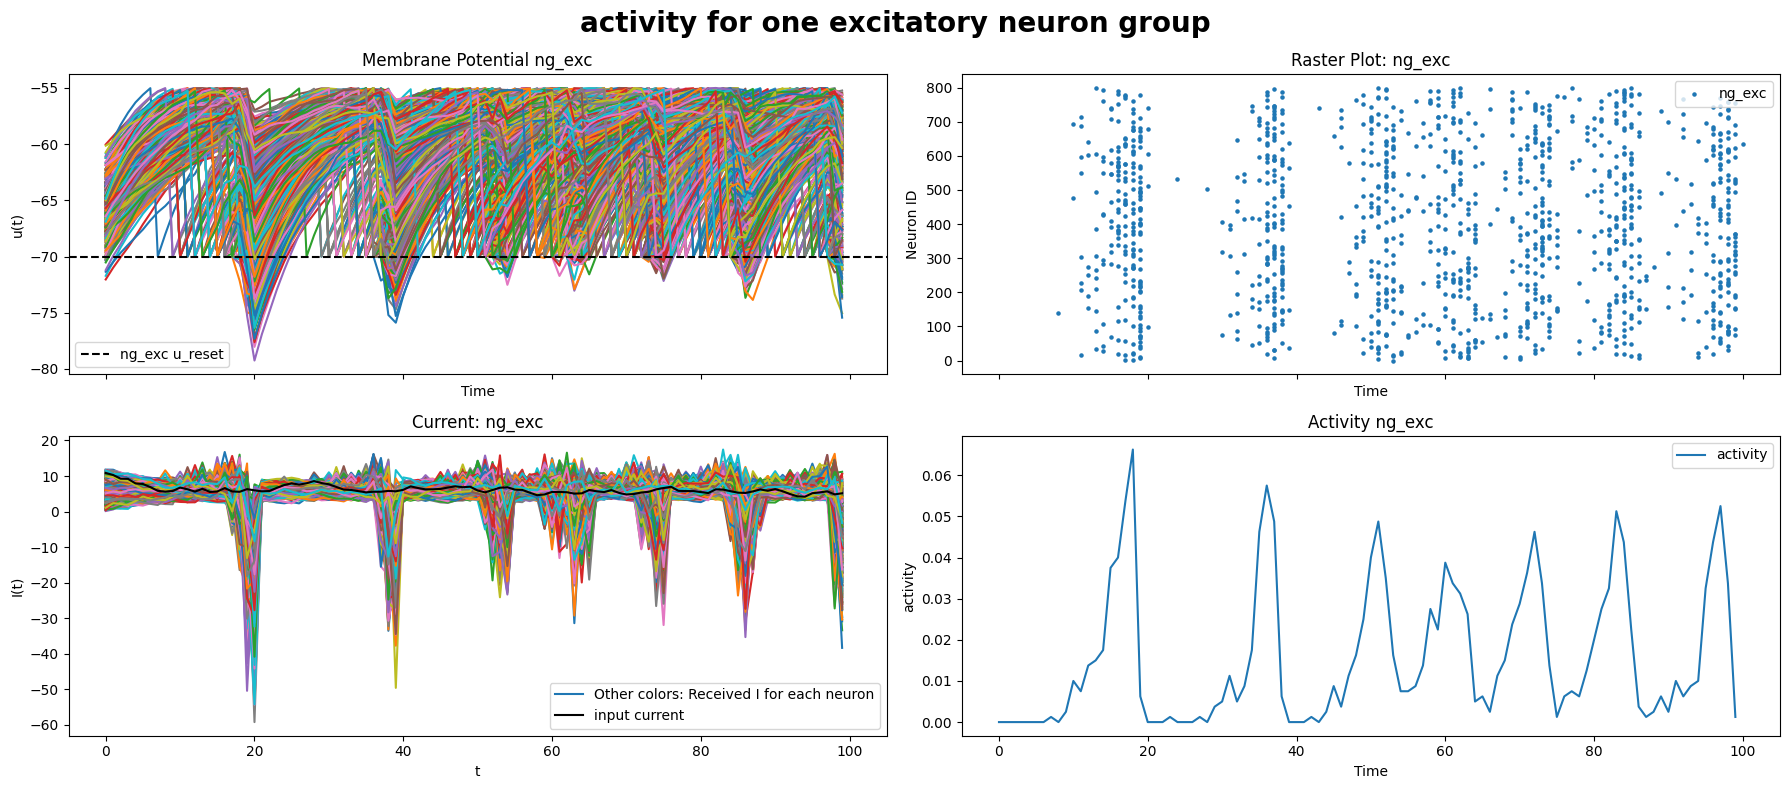

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(18, 8), sharex=True)
ng_exc.add_membrane_potential_plot(axs[0, 0], model_idx=7)
ng_exc.add_current_plot(axs[1, 0])
ng_exc.add_raster_plot(axs[0, 1])
ng_exc.add_activity_plot(axs[1, 1])
fig.suptitle("activity for one excitatory neuron group", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-fixed-synapse-80-20-rand-curr-exc.pdf")
plt.show()

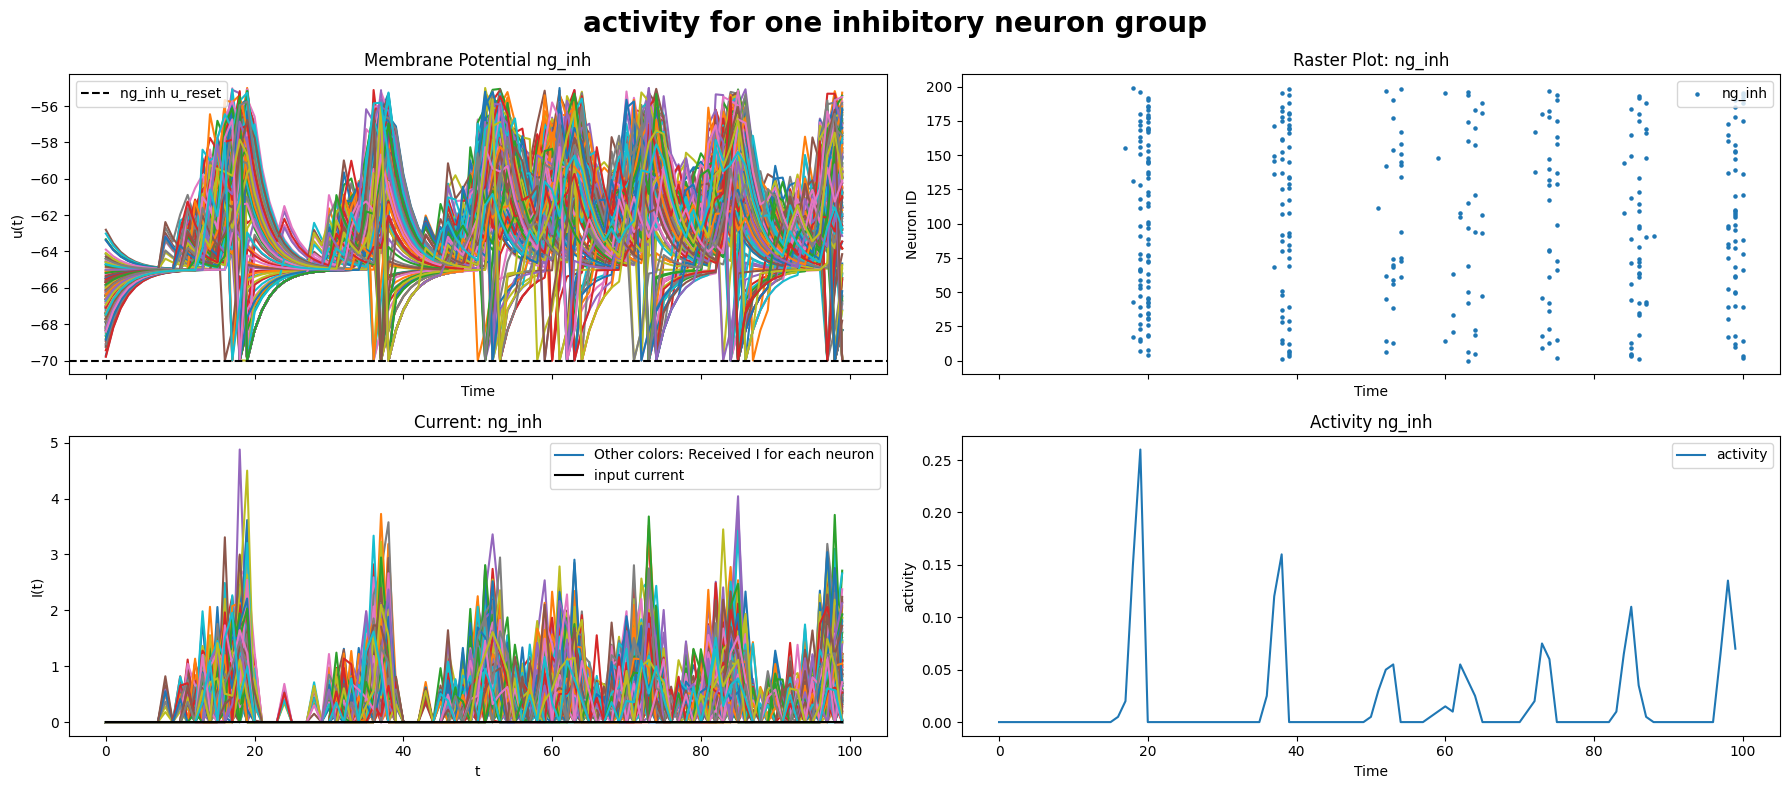

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(18, 8), sharex=True)
ng_inh.add_membrane_potential_plot(axs[0, 0], model_idx=7)
ng_inh.add_current_plot(axs[1, 0])
ng_inh.add_raster_plot(axs[0, 1])
ng_inh.add_activity_plot(axs[1, 1])
fig.suptitle("activity for one inhibitory neuron group", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-fixed-synapse-80-20-rand-curr-inh.pdf")
plt.show()

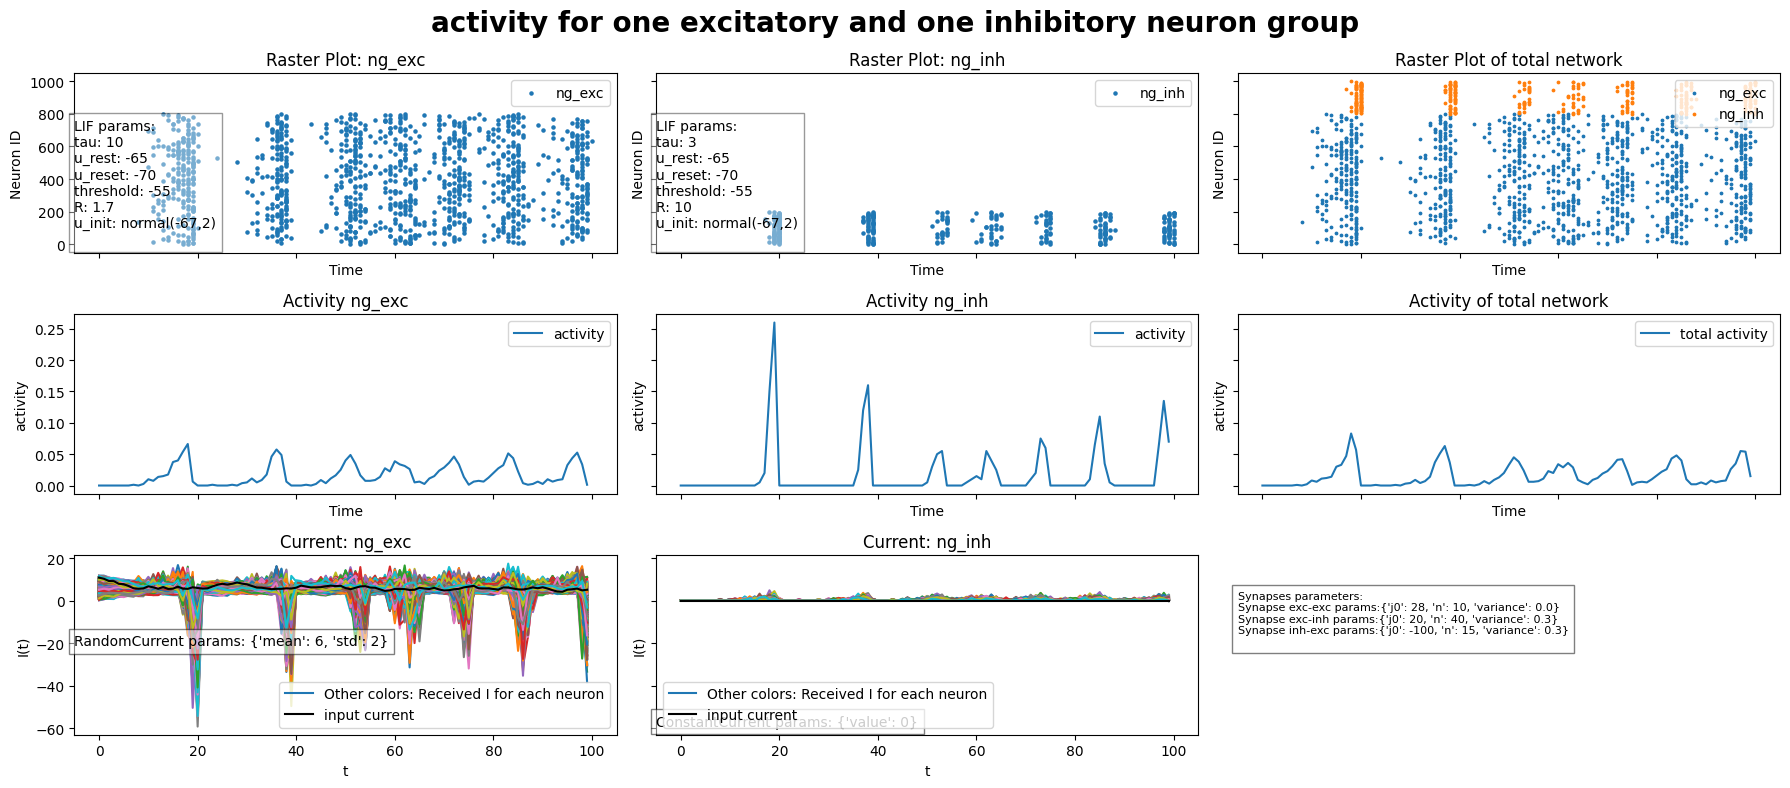

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey='row')
ng_exc.add_raster_plot(axs[0, 0])
ng_exc.add_neuron_model_params_info(axs[0, 0], model_idx=7)
ng_exc.add_activity_plot(axs[1, 0])
ng_exc.add_current_plot(axs[2, 0])
ng_exc.add_current_params_info(axs[2, 0],text_y=0.5, current_idx=2)

ng_inh.add_raster_plot(axs[0, 1])
ng_inh.add_neuron_model_params_info(axs[0, 1], model_idx=7)
ng_inh.add_activity_plot(axs[1, 1])
ng_inh.add_current_plot(axs[2, 1])
ng_inh.add_current_params_info(axs[2, 1], current_idx=2)

sim.add_raster_plot(axs[0, 2], s=3)
sim.add_activity_plot(axs[1, 2])
axs[2, 2].axis('off')
sim.add_synapses_params_info(axs[2, 2], synapse_idx=4)
plt.suptitle("activity for one excitatory and one inhibitory neuron group", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-fixed-synapse-80-20-rand-curr-total.pdf")
plt.show()


## Change in j0

In [11]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc = sim.add_neuron_group(
    tag="ng_exc",
    size=800,
    behavior={
        1: SetCurrent(0.0),
        2: RandomCurrent(mean=6, std=2),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_exc_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc_event")
    }
)
ng_inh = sim.add_neuron_group(
    tag="ng_inh",
    size=200,
    behavior={
        1: SetCurrent(0.0),
        2: ConstantCurrent(value=0),
        6: Dendrite(),
        7: LIF(
            tau=3,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=10,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_inh_rec"),
        10: EventRecorder(variables=['spike', "activity"], tag="ng_inh_event")
    }
)
syn_exc = sim.add_synapse_group(
                   tag="exc-exc",
                   src=ng_exc,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=10, n=10, variance=0.3)})

syn_exc_inh = sim.add_synapse_group(
                   tag="exc-inh",
                   src=ng_exc,
                   dst=ng_inh,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=10, n=10, variance=0.3)})
syn_inh_exc = sim.add_synapse_group(
                   tag="inh-exc",
                   src=ng_inh,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=-10, n=10, variance=0.3)})

sim.simulate(iterations=100)

Network['Network_1', 'Network'](Neurons: tensor(1000)|2 groups, Synapses: tensor(960000)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc', 'CustomNeuronGroup', 'ng'](800){1:SetCurrent(arg_0=0.0,)2:RandomCurrent(mean=6,std=2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_event,)}
NeuronGroup['ng_inh', 'CustomNeuronGroup', 'ng'](200){1:SetCurrent(arg_0=0.0,)2:ConstantCurrent(value=0,)6:Dendrite()7:LIF(tau=3,u_rest=-65,u_reset=-70,threshold=-55,R=10,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_rec,)10:EventRecorder(variables=['spike', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_

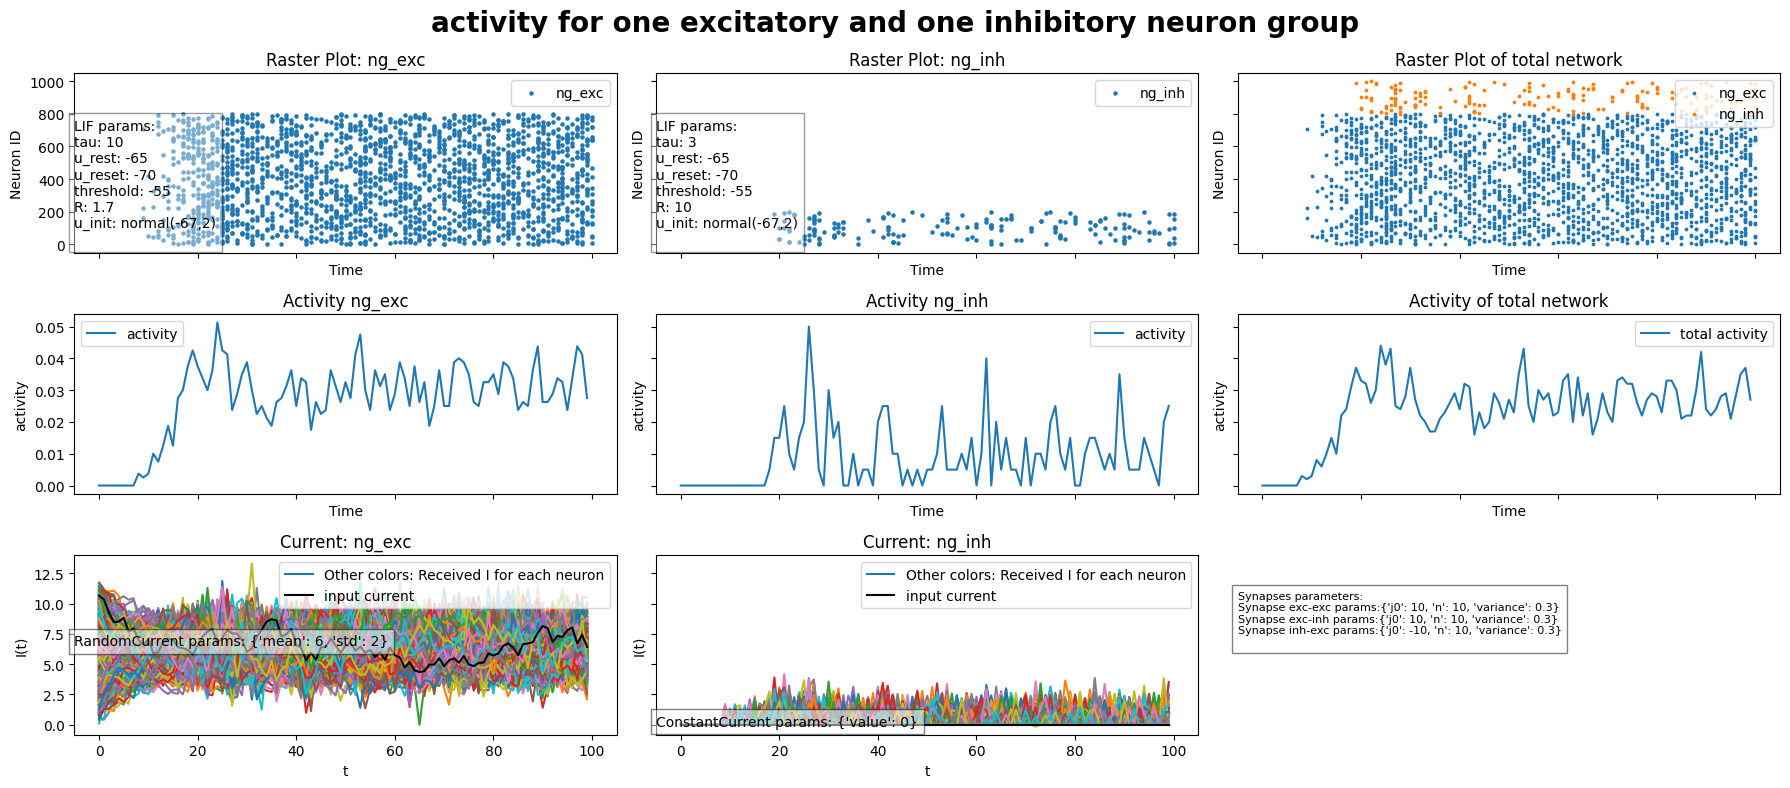

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey='row')
ng_exc.add_raster_plot(axs[0, 0])
ng_exc.add_neuron_model_params_info(axs[0, 0], model_idx=7)
ng_exc.add_activity_plot(axs[1, 0])
ng_exc.add_current_plot(axs[2, 0])
ng_exc.add_current_params_info(axs[2, 0],text_y=0.5, current_idx=2)

ng_inh.add_raster_plot(axs[0, 1])
ng_inh.add_neuron_model_params_info(axs[0, 1], model_idx=7)
ng_inh.add_activity_plot(axs[1, 1])
ng_inh.add_current_plot(axs[2, 1])
ng_inh.add_current_params_info(axs[2, 1], current_idx=2)

sim.add_raster_plot(axs[0, 2], s=3)
sim.add_activity_plot(axs[1, 2])
axs[2, 2].axis('off')
sim.add_synapses_params_info(axs[2, 2], synapse_idx=4)
plt.suptitle("activity for one excitatory and one inhibitory neuron group", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-fixed-synapse-80-20-rand-curr-same-j.pdf")
plt.show()

Increase j0 in exc-ing

In [13]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc = sim.add_neuron_group(
    tag="ng_exc",
    size=800,
    behavior={
        1: SetCurrent(0.0),
        2: RandomCurrent(mean=6, std=2),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_exc_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc_event")
    }
)
ng_inh = sim.add_neuron_group(
    tag="ng_inh",
    size=200,
    behavior={
        1: SetCurrent(0.0),
        2: ConstantCurrent(value=0),
        6: Dendrite(),
        7: LIF(
            tau=3,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=10,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_inh_rec"),
        10: EventRecorder(variables=['spike', "activity"], tag="ng_inh_event")
    }
)
syn_exc = sim.add_synapse_group(
                   tag="exc-exc",
                   src=ng_exc,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=10, n=10, variance=0.3)})

syn_exc_inh = sim.add_synapse_group(
                   tag="exc-inh",
                   src=ng_exc,
                   dst=ng_inh,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=30, n=10, variance=0.3)})
syn_inh_exc = sim.add_synapse_group(
                   tag="inh-exc",
                   src=ng_inh,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=-10, n=10, variance=0.3)})

sim.simulate(iterations=100)

Network['Network_1', 'Network'](Neurons: tensor(1000)|2 groups, Synapses: tensor(960000)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc', 'CustomNeuronGroup', 'ng'](800){1:SetCurrent(arg_0=0.0,)2:RandomCurrent(mean=6,std=2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_event,)}
NeuronGroup['ng_inh', 'CustomNeuronGroup', 'ng'](200){1:SetCurrent(arg_0=0.0,)2:ConstantCurrent(value=0,)6:Dendrite()7:LIF(tau=3,u_rest=-65,u_reset=-70,threshold=-55,R=10,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_rec,)10:EventRecorder(variables=['spike', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_

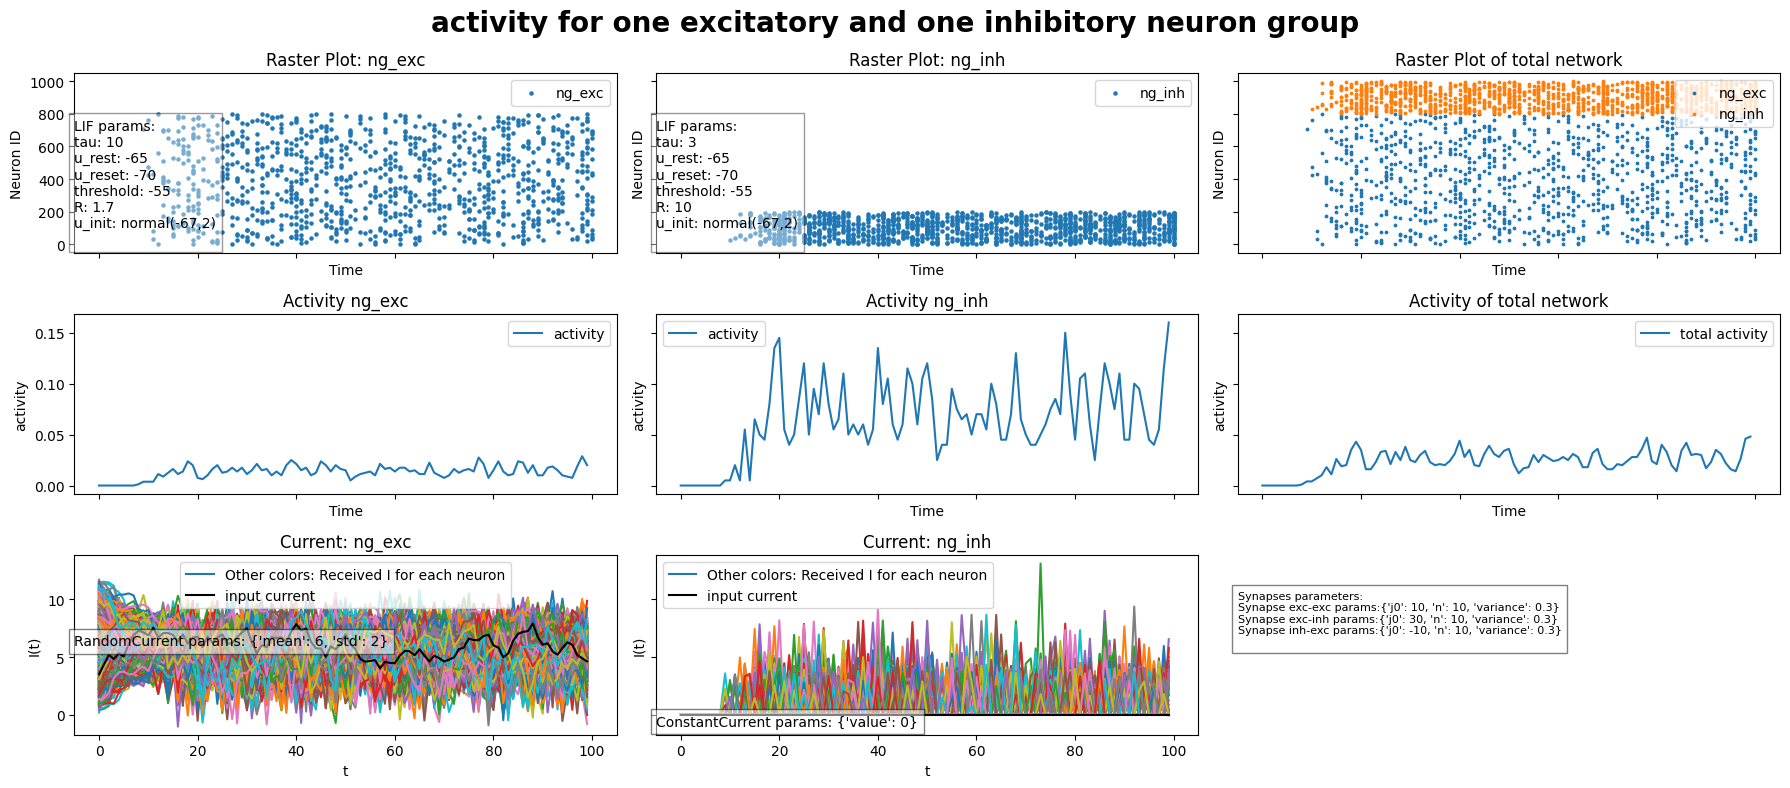

In [14]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey='row')
ng_exc.add_raster_plot(axs[0, 0])
ng_exc.add_neuron_model_params_info(axs[0, 0], model_idx=7)
ng_exc.add_activity_plot(axs[1, 0])
ng_exc.add_current_plot(axs[2, 0])
ng_exc.add_current_params_info(axs[2, 0],text_y=0.5, current_idx=2)

ng_inh.add_raster_plot(axs[0, 1])
ng_inh.add_neuron_model_params_info(axs[0, 1], model_idx=7)
ng_inh.add_activity_plot(axs[1, 1])
ng_inh.add_current_plot(axs[2, 1])
ng_inh.add_current_params_info(axs[2, 1], current_idx=2)

sim.add_raster_plot(axs[0, 2], s=3)
sim.add_activity_plot(axs[1, 2])
axs[2, 2].axis('off')
sim.add_synapses_params_info(axs[2, 2], synapse_idx=4)
plt.suptitle("activity for one excitatory and one inhibitory neuron group", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-fixed-synapse-80-20-rand-curr-increase-exc-inh-j.pdf")
plt.show()

Increase j0 in inh-exc

In [15]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc = sim.add_neuron_group(
    tag="ng_exc",
    size=800,
    behavior={
        1: SetCurrent(0.0),
        2: RandomCurrent(mean=6, std=2),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_exc_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc_event")
    }
)
ng_inh = sim.add_neuron_group(
    tag="ng_inh",
    size=200,
    behavior={
        1: SetCurrent(0.0),
        2: ConstantCurrent(value=0),
        6: Dendrite(),
        7: LIF(
            tau=3,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=10,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_inh_rec"),
        10: EventRecorder(variables=['spike', "activity"], tag="ng_inh_event")
    }
)
syn_exc = sim.add_synapse_group(
                   tag="exc-exc",
                   src=ng_exc,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=10, n=10, variance=0.3)})

syn_exc_inh = sim.add_synapse_group(
                   tag="exc-inh",
                   src=ng_exc,
                   dst=ng_inh,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=10, n=10, variance=0.3)})
syn_inh_exc = sim.add_synapse_group(
                   tag="inh-exc",
                   src=ng_inh,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=-100, n=10, variance=0.3)})

sim.simulate(iterations=100)

Network['Network_1', 'Network'](Neurons: tensor(1000)|2 groups, Synapses: tensor(960000)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc', 'CustomNeuronGroup', 'ng'](800){1:SetCurrent(arg_0=0.0,)2:RandomCurrent(mean=6,std=2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_event,)}
NeuronGroup['ng_inh', 'CustomNeuronGroup', 'ng'](200){1:SetCurrent(arg_0=0.0,)2:ConstantCurrent(value=0,)6:Dendrite()7:LIF(tau=3,u_rest=-65,u_reset=-70,threshold=-55,R=10,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_rec,)10:EventRecorder(variables=['spike', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_

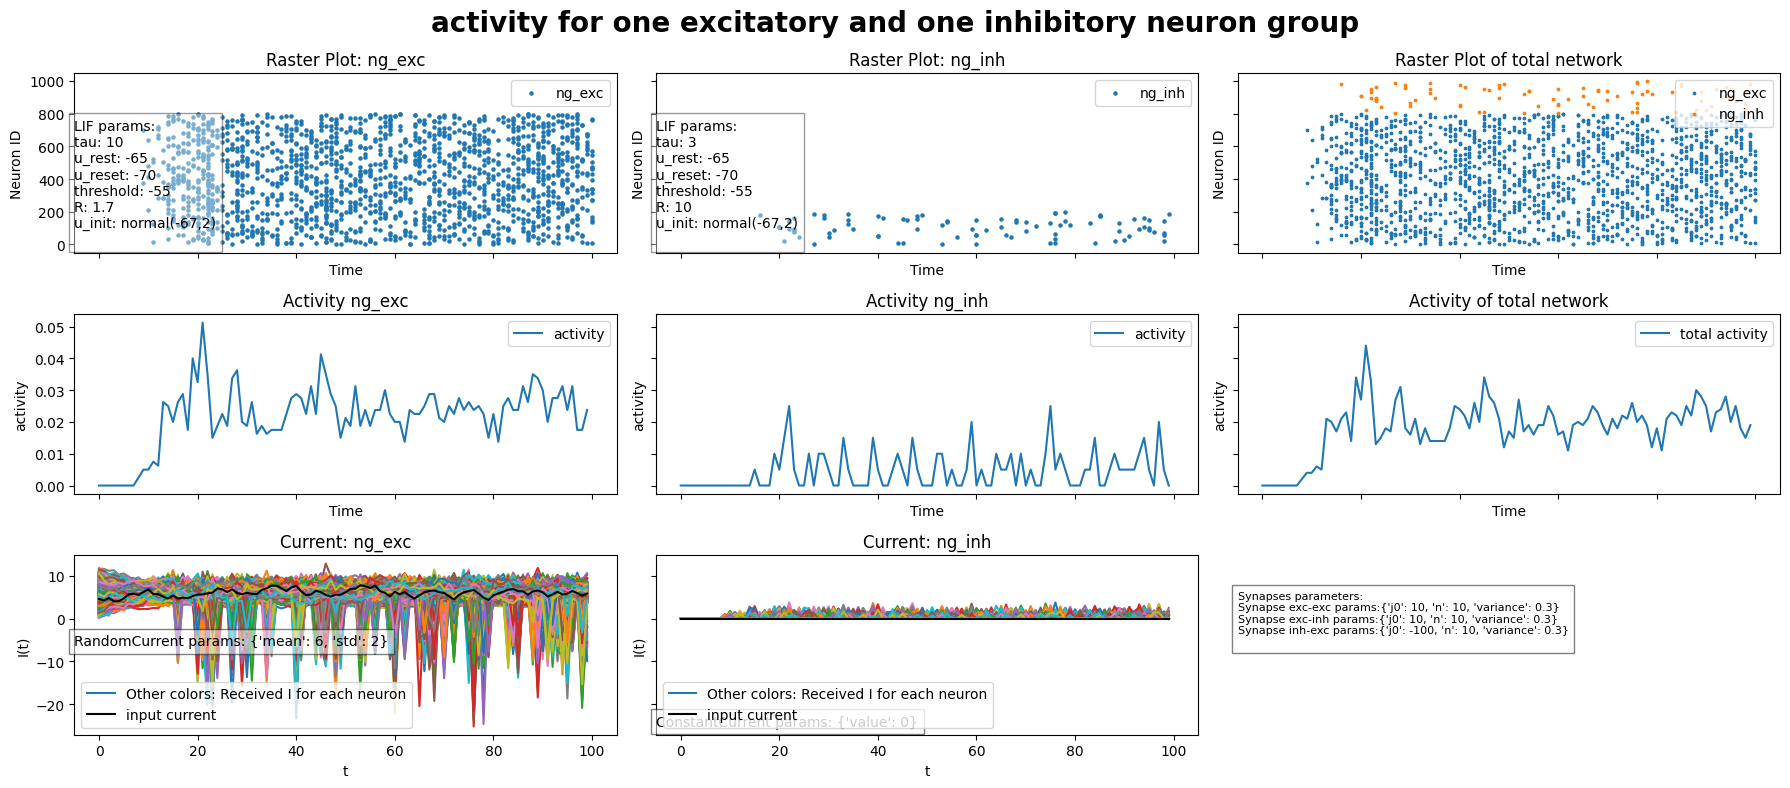

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey='row')
ng_exc.add_raster_plot(axs[0, 0])
ng_exc.add_neuron_model_params_info(axs[0, 0], model_idx=7)
ng_exc.add_activity_plot(axs[1, 0])
ng_exc.add_current_plot(axs[2, 0])
ng_exc.add_current_params_info(axs[2, 0],text_y=0.5, current_idx=2)

ng_inh.add_raster_plot(axs[0, 1])
ng_inh.add_neuron_model_params_info(axs[0, 1], model_idx=7)
ng_inh.add_activity_plot(axs[1, 1])
ng_inh.add_current_plot(axs[2, 1])
ng_inh.add_current_params_info(axs[2, 1], current_idx=2)

sim.add_raster_plot(axs[0, 2], s=3)
sim.add_activity_plot(axs[1, 2])
axs[2, 2].axis('off')
sim.add_synapses_params_info(axs[2, 2], synapse_idx=4)
plt.suptitle("activity for one excitatory and one inhibitory neuron group", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-fixed-synapse-80-20-rand-curr-increase-inh-exc-j.pdf")
plt.show()

Increase j0 in exc-exc

In [17]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc = sim.add_neuron_group(
    tag="ng_exc",
    size=800,
    behavior={
        1: SetCurrent(0.0),
        2: RandomCurrent(mean=6, std=2),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_exc_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc_event")
    }
)
ng_inh = sim.add_neuron_group(
    tag="ng_inh",
    size=200,
    behavior={
        1: SetCurrent(0.0),
        2: ConstantCurrent(value=0),
        6: Dendrite(),
        7: LIF(
            tau=3,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=10,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_inh_rec"),
        10: EventRecorder(variables=['spike', "activity"], tag="ng_inh_event")
    }
)
syn_exc = sim.add_synapse_group(
                   tag="exc-exc",
                   src=ng_exc,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=30, n=10, variance=0.3)})

syn_exc_inh = sim.add_synapse_group(
                   tag="exc-inh",
                   src=ng_exc,
                   dst=ng_inh,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=10, n=10, variance=0.3)})
syn_inh_exc = sim.add_synapse_group(
                   tag="inh-exc",
                   src=ng_inh,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=-10, n=10, variance=0.3)})

sim.simulate(iterations=100)

Network['Network_1', 'Network'](Neurons: tensor(1000)|2 groups, Synapses: tensor(960000)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc', 'CustomNeuronGroup', 'ng'](800){1:SetCurrent(arg_0=0.0,)2:RandomCurrent(mean=6,std=2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_event,)}
NeuronGroup['ng_inh', 'CustomNeuronGroup', 'ng'](200){1:SetCurrent(arg_0=0.0,)2:ConstantCurrent(value=0,)6:Dendrite()7:LIF(tau=3,u_rest=-65,u_reset=-70,threshold=-55,R=10,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_rec,)10:EventRecorder(variables=['spike', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_

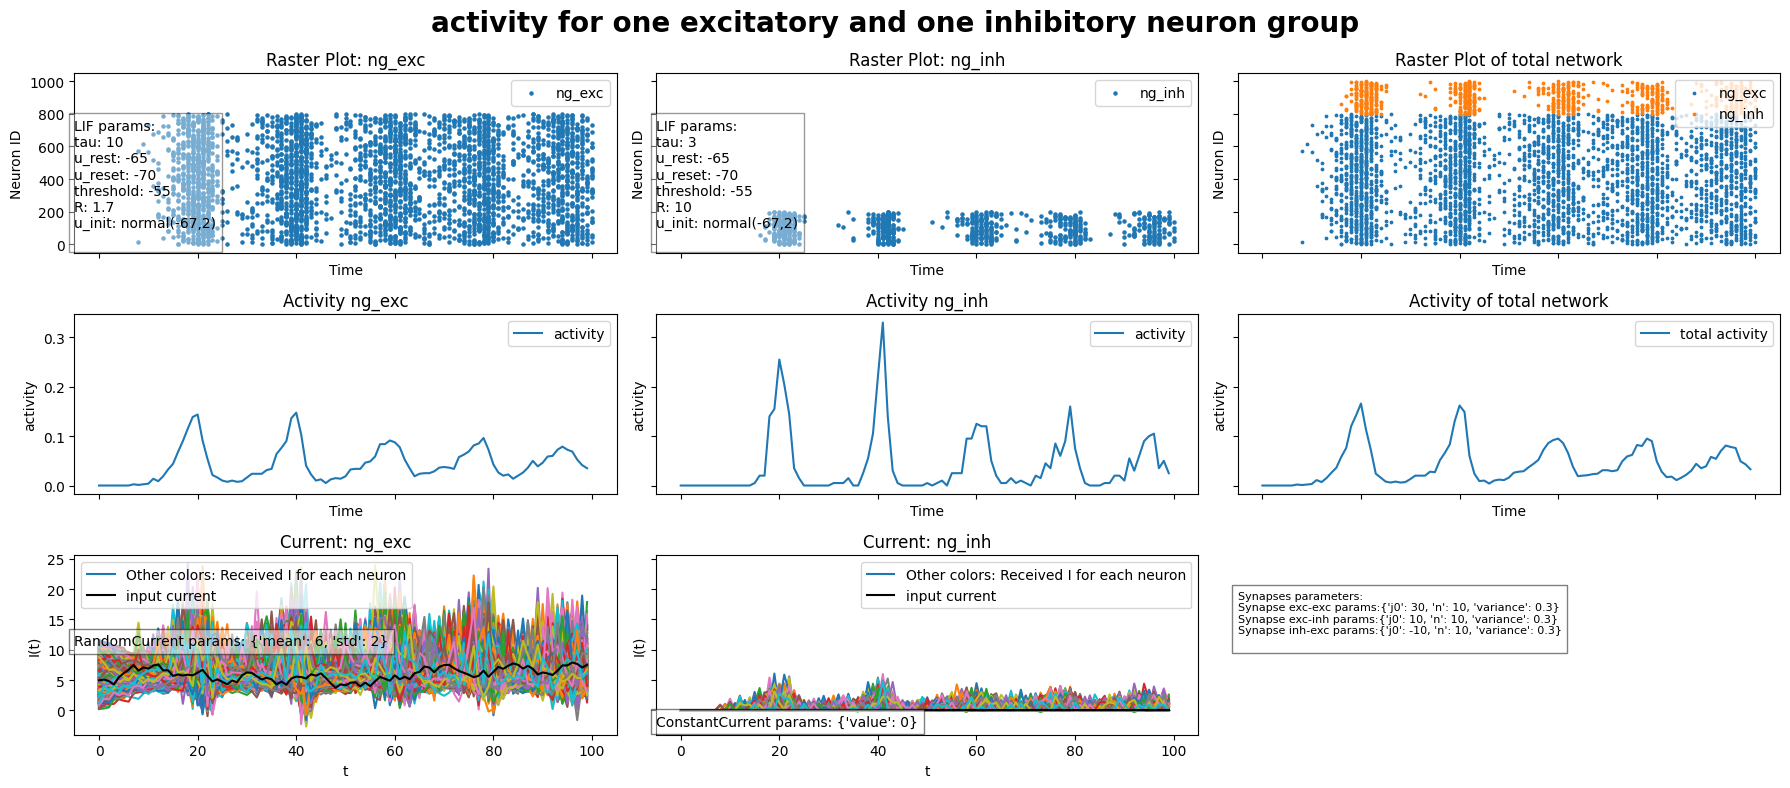

In [18]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey='row')
ng_exc.add_raster_plot(axs[0, 0])
ng_exc.add_neuron_model_params_info(axs[0, 0], model_idx=7)
ng_exc.add_activity_plot(axs[1, 0])
ng_exc.add_current_plot(axs[2, 0])
ng_exc.add_current_params_info(axs[2, 0],text_y=0.5, current_idx=2)

ng_inh.add_raster_plot(axs[0, 1])
ng_inh.add_neuron_model_params_info(axs[0, 1], model_idx=7)
ng_inh.add_activity_plot(axs[1, 1])
ng_inh.add_current_plot(axs[2, 1])
ng_inh.add_current_params_info(axs[2, 1], current_idx=2)

sim.add_raster_plot(axs[0, 2], s=3)
sim.add_activity_plot(axs[1, 2])
axs[2, 2].axis('off')
sim.add_synapses_params_info(axs[2, 2], synapse_idx=4)
plt.suptitle("activity for one excitatory and one inhibitory neuron group", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-fixed-synapse-80-20-rand-curr-increase-exc-exc-j.pdf")
plt.show()

## Change in n

Increase n in exc-inh

In [19]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc = sim.add_neuron_group(
    tag="ng_exc",
    size=800,
    behavior={
        1: SetCurrent(0.0),
        2: RandomCurrent(mean=6, std=2),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_exc_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc_event")
    }
)
ng_inh = sim.add_neuron_group(
    tag="ng_inh",
    size=200,
    behavior={
        1: SetCurrent(0.0),
        2: ConstantCurrent(value=0),
        6: Dendrite(),
        7: LIF(
            tau=3,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=10,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_inh_rec"),
        10: EventRecorder(variables=['spike', "activity"], tag="ng_inh_event")
    }
)
syn_exc = sim.add_synapse_group(
                   tag="exc-exc",
                   src=ng_exc,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=10, n=10, variance=0.3)})

syn_exc_inh = sim.add_synapse_group(
                   tag="exc-inh",
                   src=ng_exc,
                   dst=ng_inh,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=10, n=20, variance=0.3)})
syn_inh_exc = sim.add_synapse_group(
                   tag="inh-exc",
                   src=ng_inh,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=-10, n=10, variance=0.3)})

sim.simulate(iterations=100)

Network['Network_1', 'Network'](Neurons: tensor(1000)|2 groups, Synapses: tensor(960000)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc', 'CustomNeuronGroup', 'ng'](800){1:SetCurrent(arg_0=0.0,)2:RandomCurrent(mean=6,std=2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_event,)}
NeuronGroup['ng_inh', 'CustomNeuronGroup', 'ng'](200){1:SetCurrent(arg_0=0.0,)2:ConstantCurrent(value=0,)6:Dendrite()7:LIF(tau=3,u_rest=-65,u_reset=-70,threshold=-55,R=10,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_rec,)10:EventRecorder(variables=['spike', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_

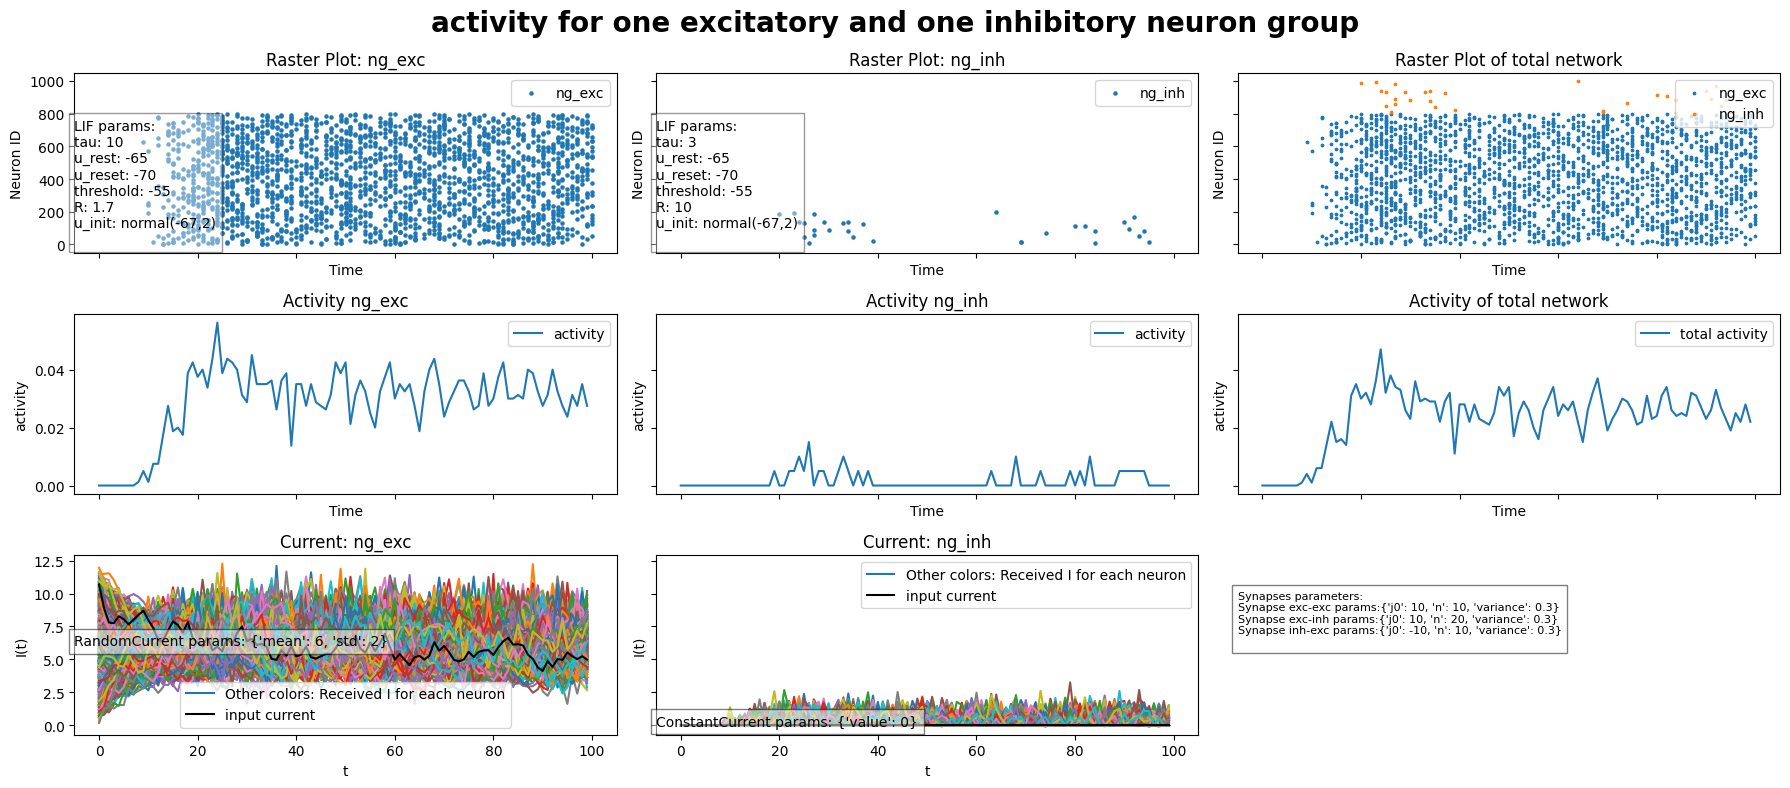

In [20]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey='row')
ng_exc.add_raster_plot(axs[0, 0])
ng_exc.add_neuron_model_params_info(axs[0, 0], model_idx=7)
ng_exc.add_activity_plot(axs[1, 0])
ng_exc.add_current_plot(axs[2, 0])
ng_exc.add_current_params_info(axs[2, 0],text_y=0.5, current_idx=2)

ng_inh.add_raster_plot(axs[0, 1])
ng_inh.add_neuron_model_params_info(axs[0, 1], model_idx=7)
ng_inh.add_activity_plot(axs[1, 1])
ng_inh.add_current_plot(axs[2, 1])
ng_inh.add_current_params_info(axs[2, 1], current_idx=2)

sim.add_raster_plot(axs[0, 2], s=3)
sim.add_activity_plot(axs[1, 2])
axs[2, 2].axis('off')
sim.add_synapses_params_info(axs[2, 2], synapse_idx=4)
plt.suptitle("activity for one excitatory and one inhibitory neuron group", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-fixed-synapse-80-20-rand-curr-increase-exc-inh-n.pdf")
plt.show()

increase n in inh-exc

In [21]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc = sim.add_neuron_group(
    tag="ng_exc",
    size=800,
    behavior={
        1: SetCurrent(0.0),
        2: RandomCurrent(mean=6, std=2),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_exc_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc_event")
    }
)
ng_inh = sim.add_neuron_group(
    tag="ng_inh",
    size=200,
    behavior={
        1: SetCurrent(0.0),
        2: ConstantCurrent(value=0),
        6: Dendrite(),
        7: LIF(
            tau=3,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=10,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_inh_rec"),
        10: EventRecorder(variables=['spike', "activity"], tag="ng_inh_event")
    }
)
syn_exc = sim.add_synapse_group(
                   tag="exc-exc",
                   src=ng_exc,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=10, n=10, variance=0.3)})

syn_exc_inh = sim.add_synapse_group(
                   tag="exc-inh",
                   src=ng_exc,
                   dst=ng_inh,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=10, n=10, variance=0.3)})
syn_inh_exc = sim.add_synapse_group(
                   tag="inh-exc",
                   src=ng_inh,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=-10, n=50, variance=0.3)})

sim.simulate(iterations=100)

Network['Network_1', 'Network'](Neurons: tensor(1000)|2 groups, Synapses: tensor(960000)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc', 'CustomNeuronGroup', 'ng'](800){1:SetCurrent(arg_0=0.0,)2:RandomCurrent(mean=6,std=2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_event,)}
NeuronGroup['ng_inh', 'CustomNeuronGroup', 'ng'](200){1:SetCurrent(arg_0=0.0,)2:ConstantCurrent(value=0,)6:Dendrite()7:LIF(tau=3,u_rest=-65,u_reset=-70,threshold=-55,R=10,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_rec,)10:EventRecorder(variables=['spike', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_

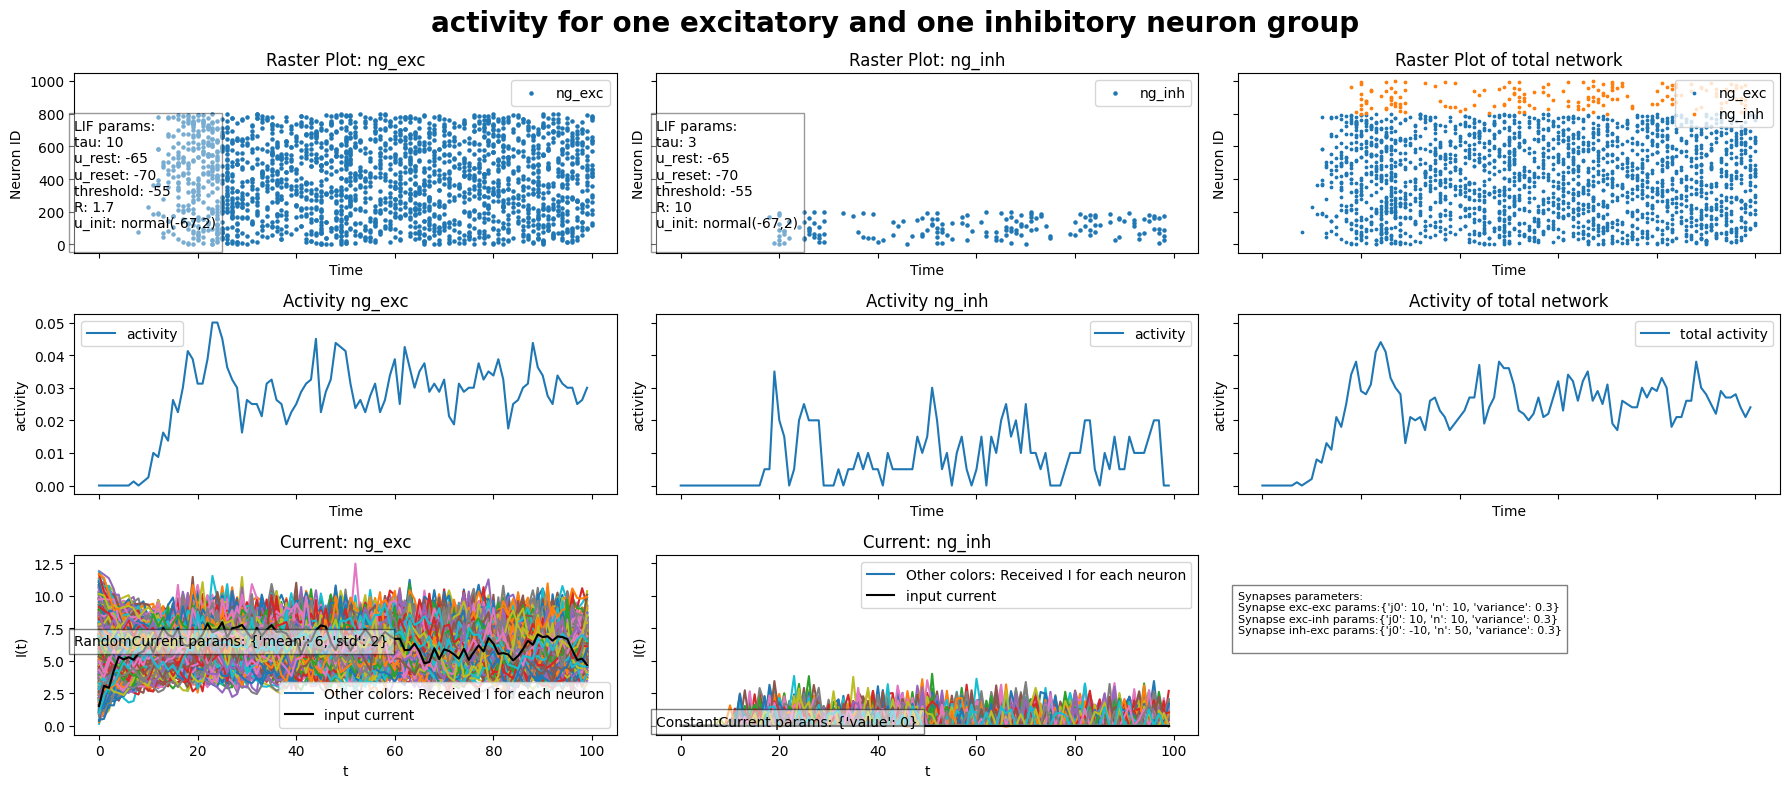

In [22]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey='row')
ng_exc.add_raster_plot(axs[0, 0])
ng_exc.add_neuron_model_params_info(axs[0, 0], model_idx=7)
ng_exc.add_activity_plot(axs[1, 0])
ng_exc.add_current_plot(axs[2, 0])
ng_exc.add_current_params_info(axs[2, 0],text_y=0.5, current_idx=2)

ng_inh.add_raster_plot(axs[0, 1])
ng_inh.add_neuron_model_params_info(axs[0, 1], model_idx=7)
ng_inh.add_activity_plot(axs[1, 1])
ng_inh.add_current_plot(axs[2, 1])
ng_inh.add_current_params_info(axs[2, 1], current_idx=2)

sim.add_raster_plot(axs[0, 2], s=3)
sim.add_activity_plot(axs[1, 2])
axs[2, 2].axis('off')
sim.add_synapses_params_info(axs[2, 2], synapse_idx=4)
plt.suptitle("activity for one excitatory and one inhibitory neuron group", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-fixed-synapse-80-20-rand-curr-increase-inh-exc-n.pdf")
plt.show()

## Change in p

In [23]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc = sim.add_neuron_group(
    tag="ng_exc",
    size=800,
    behavior={
        1: SetCurrent(0.0),
        2: RandomCurrent(mean=6, std=2),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_exc_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc_event")
    }
)
ng_inh = sim.add_neuron_group(
    tag="ng_inh",
    size=200,
    behavior={
        1: SetCurrent(0.0),
        2: ConstantCurrent(value=0),
        6: Dendrite(),
        7: LIF(
            tau=3,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=10,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_inh_rec"),
        10: EventRecorder(variables=['spike', "activity"], tag="ng_inh_event")
    }
)
syn_exc = sim.add_synapse_group(
                   tag="exc-exc",
                   src=ng_exc,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedProbSynapse(j0=10, p=0.01, variance=0.3)})

syn_exc_inh = sim.add_synapse_group(
                   tag="exc-inh",
                   src=ng_exc,
                   dst=ng_inh,
                   behavior={4: RandomConnectedFixedProbSynapse(j0=10, p=0.01, variance=0.3)})
syn_inh_exc = sim.add_synapse_group(
                   tag="inh-exc",
                   src=ng_inh,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedProbSynapse(j0=-10, p=0.05, variance=0.3)})

sim.simulate(iterations=100)

Network['Network_1', 'Network'](Neurons: tensor(1000)|2 groups, Synapses: tensor(960000)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc', 'CustomNeuronGroup', 'ng'](800){1:SetCurrent(arg_0=0.0,)2:RandomCurrent(mean=6,std=2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_event,)}
NeuronGroup['ng_inh', 'CustomNeuronGroup', 'ng'](200){1:SetCurrent(arg_0=0.0,)2:ConstantCurrent(value=0,)6:Dendrite()7:LIF(tau=3,u_rest=-65,u_reset=-70,threshold=-55,R=10,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_rec,)10:EventRecorder(variables=['spike', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_

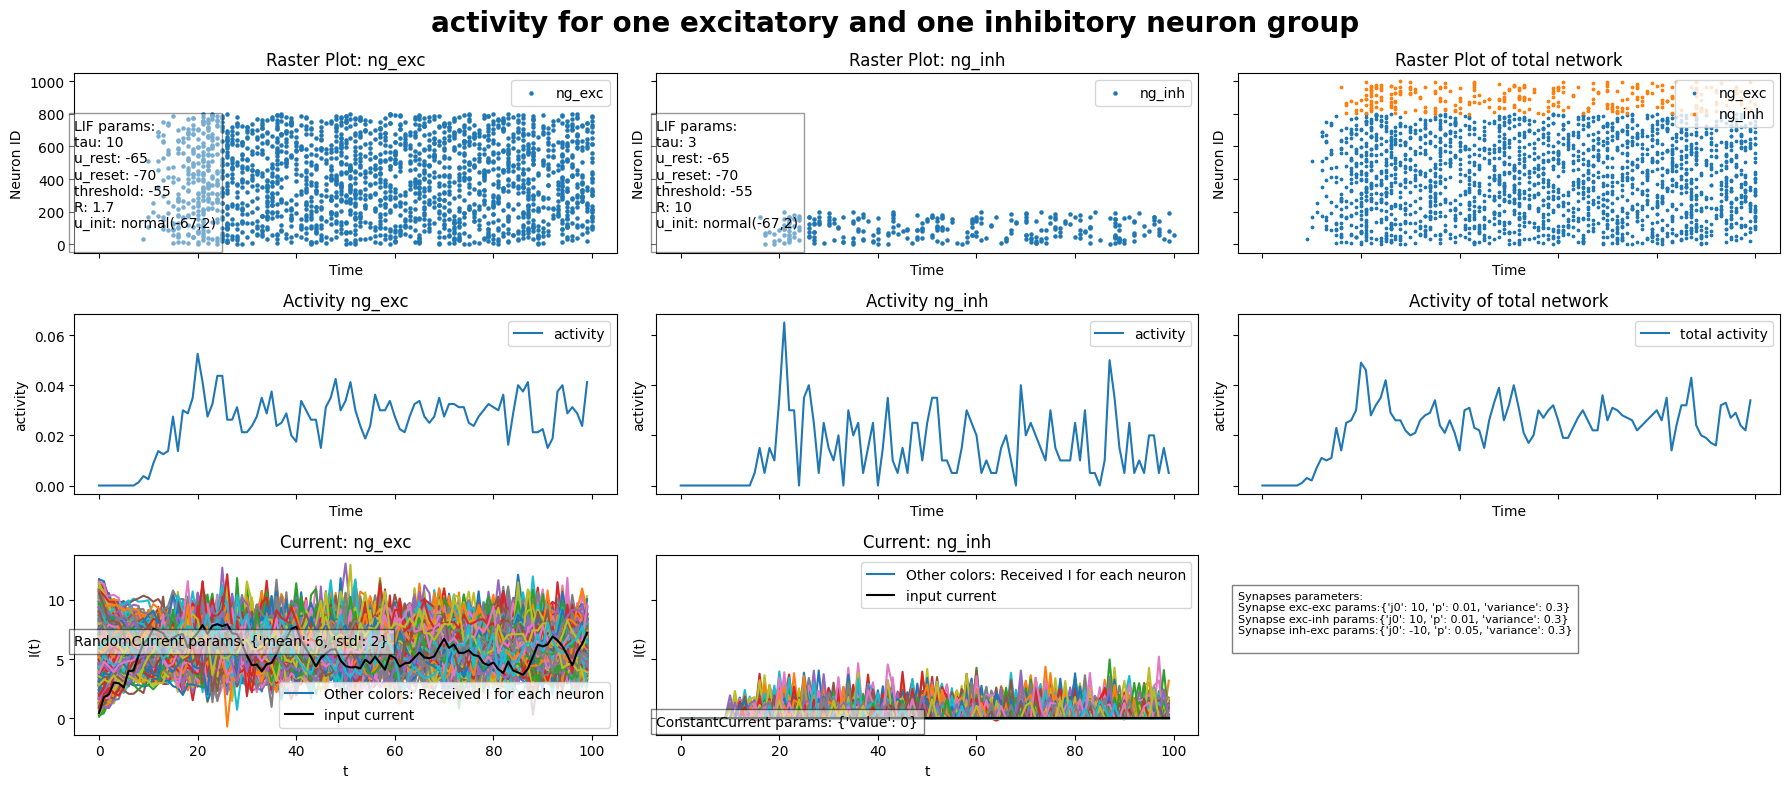

In [24]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey='row')
ng_exc.add_raster_plot(axs[0, 0])
ng_exc.add_neuron_model_params_info(axs[0, 0], model_idx=7)
ng_exc.add_activity_plot(axs[1, 0])
ng_exc.add_current_plot(axs[2, 0])
ng_exc.add_current_params_info(axs[2, 0],text_y=0.5, current_idx=2)

ng_inh.add_raster_plot(axs[0, 1])
ng_inh.add_neuron_model_params_info(axs[0, 1], model_idx=7)
ng_inh.add_activity_plot(axs[1, 1])
ng_inh.add_current_plot(axs[2, 1])
ng_inh.add_current_params_info(axs[2, 1], current_idx=2)

sim.add_raster_plot(axs[0, 2], s=3)
sim.add_activity_plot(axs[1, 2])
axs[2, 2].axis('off')
sim.add_synapses_params_info(axs[2, 2], synapse_idx=4)
plt.suptitle("activity for one excitatory and one inhibitory neuron group", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-prob-synapse-80-20-rand-curr-increase-exc-inh-p.pdf")
plt.show()

### Change in size

In [25]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc = sim.add_neuron_group(
    tag="ng_exc",
    size=80,
    behavior={
        1: SetCurrent(0.0),
        # 2: ConstantCurrent(value=6),
        2: RandomCurrent(mean=6, std=2),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_exc_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc_event")
    }
)
ng_inh = sim.add_neuron_group(
    tag="ng_inh",
    size=20,
    behavior={
        1: SetCurrent(0.0),
        2: ConstantCurrent(value=0),
        6: Dendrite(),
        7: LIF(
            tau=3,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=10,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_inh_rec"),
        10: EventRecorder(variables=['spike', "activity"], tag="ng_inh_event")
    }
)
syn_exc = sim.add_synapse_group(
                   tag="exc-exc",
                   src=ng_exc,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=10, n=10, variance=0.0)})
# syn_inh = net.add_synapse_group(
#                    tag="inh-inh",
#                    src=ng_inh,
#                    dst=ng_inh,
#                    behavior={4: RandomConnectedFixedInputSynapse(j0=-100, n=50, variance=0.45, alpha=0.9)})
syn_exc_inh = sim.add_synapse_group(
                   tag="exc-inh",
                   src=ng_exc,
                   dst=ng_inh,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=10, n=10, variance=0.3)})
syn_inh_exc = sim.add_synapse_group(
                   tag="inh-exc",
                   src=ng_inh,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedInputSynapse(j0=-10, n=10, variance=0.3)})
sim.simulate(iterations=100)


Network['Network_1', 'Network'](Neurons: tensor(100)|2 groups, Synapses: tensor(9600)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc', 'CustomNeuronGroup', 'ng'](80){1:SetCurrent(arg_0=0.0,)2:RandomCurrent(mean=6,std=2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_event,)}
NeuronGroup['ng_inh', 'CustomNeuronGroup', 'ng'](20){1:SetCurrent(arg_0=0.0,)2:ConstantCurrent(value=0,)6:Dendrite()7:LIF(tau=3,u_rest=-65,u_reset=-70,threshold=-55,R=10,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_rec,)10:EventRecorder(variables=['spike', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_event

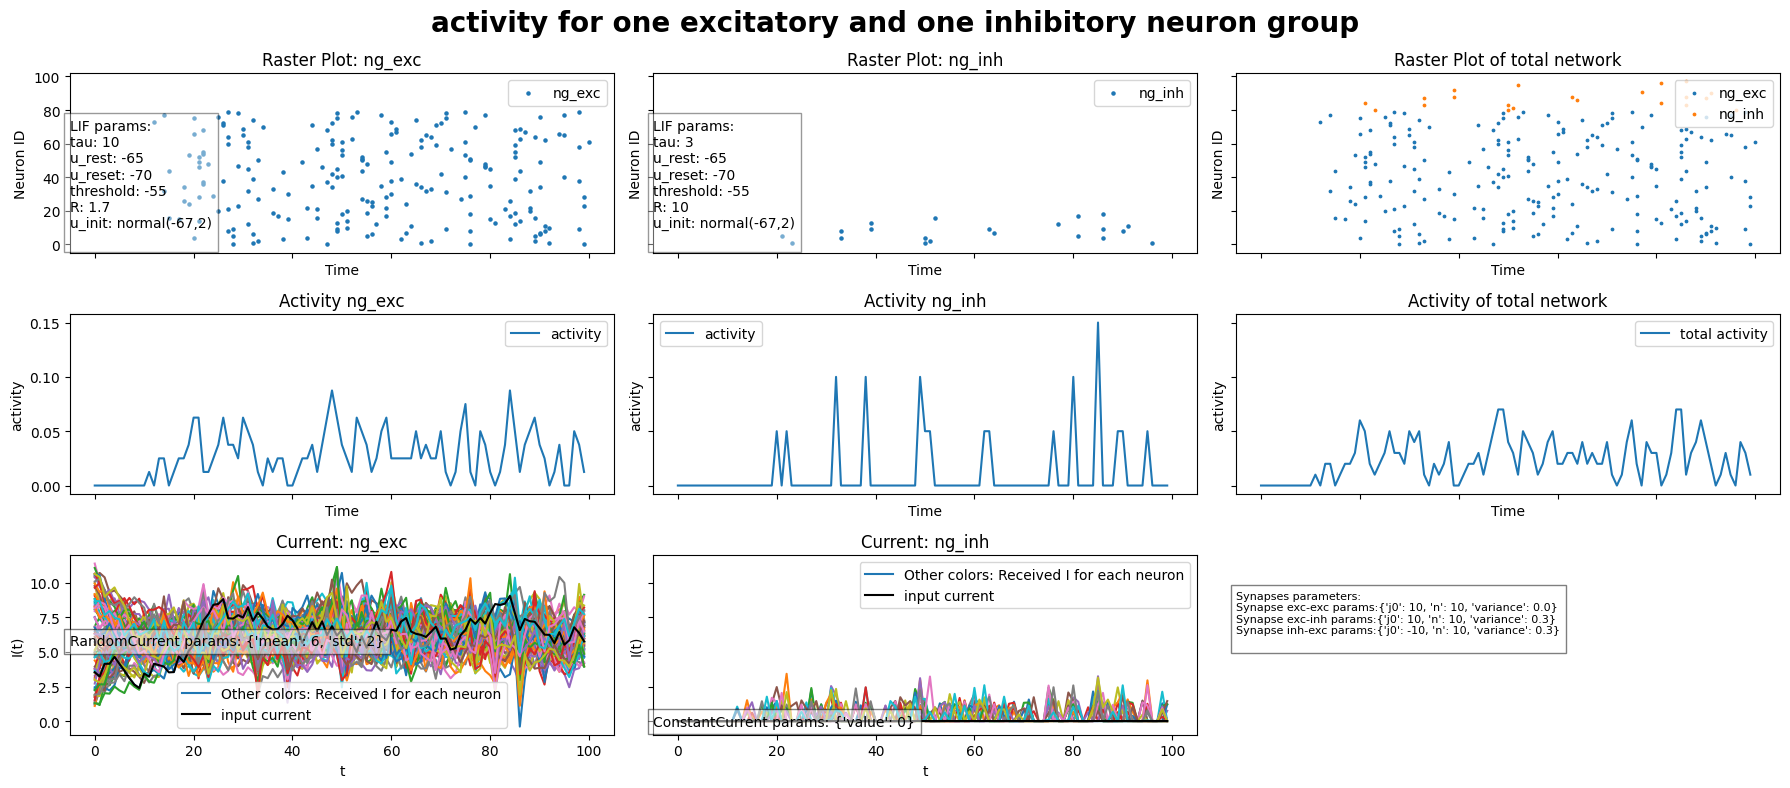

In [26]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey='row')
ng_exc.add_raster_plot(axs[0, 0])
ng_exc.add_neuron_model_params_info(axs[0, 0], model_idx=7)
ng_exc.add_activity_plot(axs[1, 0])
ng_exc.add_current_plot(axs[2, 0])
ng_exc.add_current_params_info(axs[2, 0],text_y=0.5, current_idx=2)

ng_inh.add_raster_plot(axs[0, 1])
ng_inh.add_neuron_model_params_info(axs[0, 1], model_idx=7)
ng_inh.add_activity_plot(axs[1, 1])
ng_inh.add_current_plot(axs[2, 1])
ng_inh.add_current_params_info(axs[2, 1], current_idx=2)

sim.add_raster_plot(axs[0, 2], s=3)
sim.add_activity_plot(axs[1, 2])
axs[2, 2].axis('off')
sim.add_synapses_params_info(axs[2, 2], synapse_idx=4)
plt.suptitle("activity for one excitatory and one inhibitory neuron group", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-fixed-synapse-80-20-rand-curr-less-size.pdf")
plt.show()

In [27]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc = sim.add_neuron_group(
    tag="ng_exc",
    size=80,
    behavior={
        1: SetCurrent(0.0),
        2: RandomCurrent(mean=6, std=2),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_exc_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc_event")
    }
)
ng_inh = sim.add_neuron_group(
    tag="ng_inh",
    size=20,
    behavior={
        1: SetCurrent(0.0),
        2: ConstantCurrent(value=0),
        6: Dendrite(),
        7: LIF(
            tau=3,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=10,
            u_init="normal(-67,2)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I","inp_I", "activity"], tag="ng_inh_rec"),
        10: EventRecorder(variables=['spike', "activity"], tag="ng_inh_event")
    }
)
syn_exc = sim.add_synapse_group(
                   tag="exc-exc",
                   src=ng_exc,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedProbSynapse(j0=10, p=0.01, variance=0.3)})

syn_exc_inh = sim.add_synapse_group(
                   tag="exc-inh",
                   src=ng_exc,
                   dst=ng_inh,
                   behavior={4: RandomConnectedFixedProbSynapse(j0=10, p=0.01, variance=0.3)})
syn_inh_exc = sim.add_synapse_group(
                   tag="inh-exc",
                   src=ng_inh,
                   dst=ng_exc,
                   behavior={4: RandomConnectedFixedProbSynapse(j0=-10, p=0.05, variance=0.3)})

sim.simulate(iterations=100)

Network['Network_1', 'Network'](Neurons: tensor(100)|2 groups, Synapses: tensor(9600)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc', 'CustomNeuronGroup', 'ng'](80){1:SetCurrent(arg_0=0.0,)2:RandomCurrent(mean=6,std=2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc_event,)}
NeuronGroup['ng_inh', 'CustomNeuronGroup', 'ng'](20){1:SetCurrent(arg_0=0.0,)2:ConstantCurrent(value=0,)6:Dendrite()7:LIF(tau=3,u_rest=-65,u_reset=-70,threshold=-55,R=10,u_init=normal(-67,2),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_rec,)10:EventRecorder(variables=['spike', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inh_event

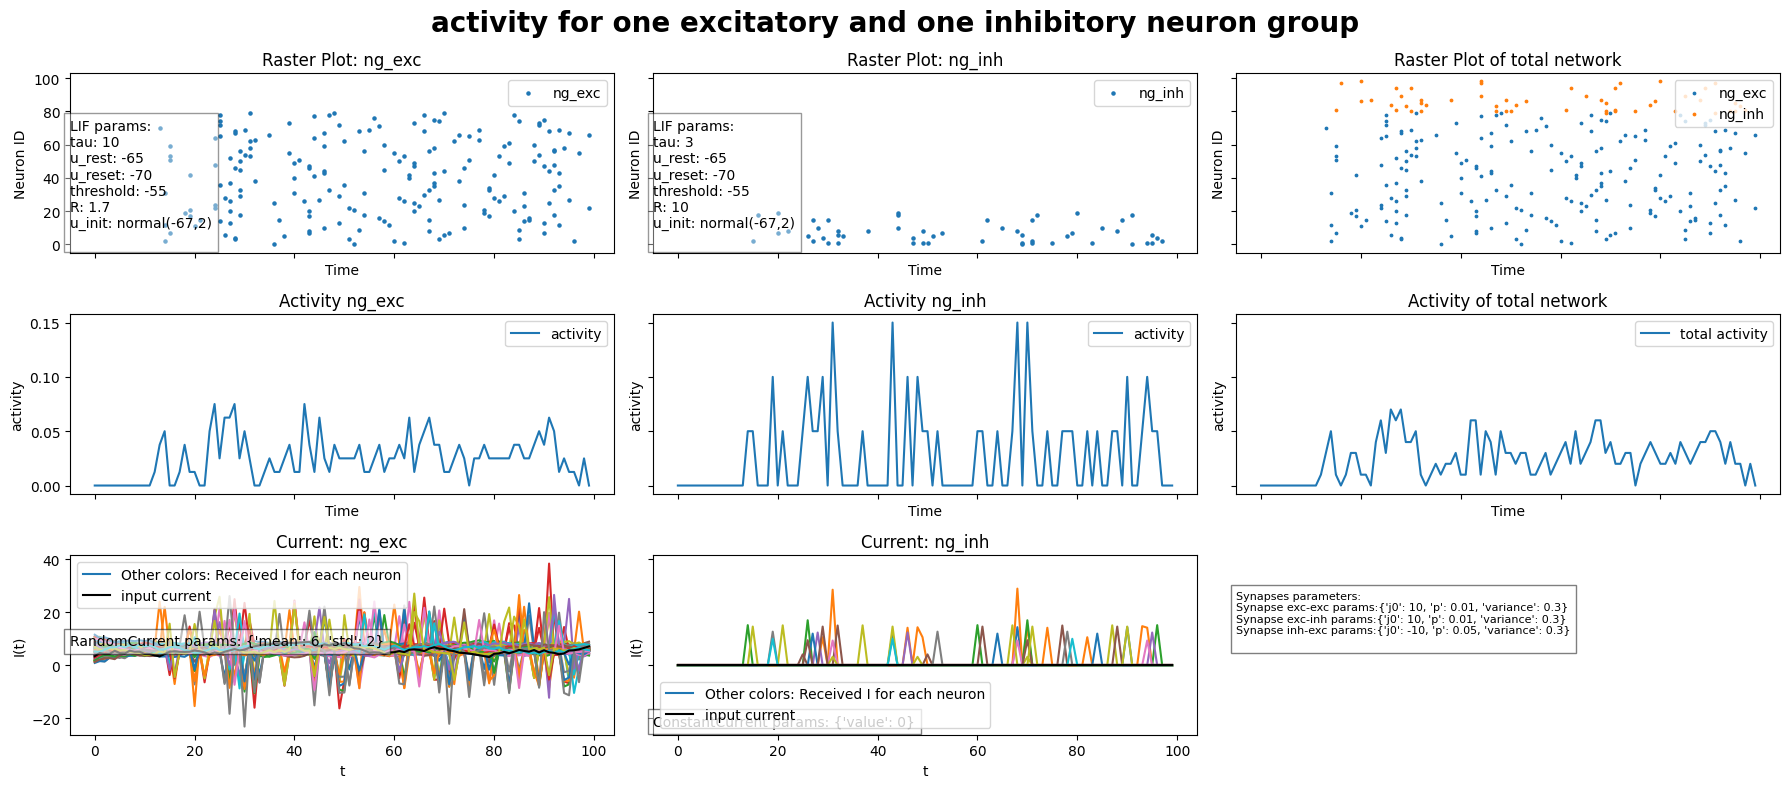

In [28]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey='row')
ng_exc.add_raster_plot(axs[0, 0])
ng_exc.add_neuron_model_params_info(axs[0, 0], model_idx=7)
ng_exc.add_activity_plot(axs[1, 0])
ng_exc.add_current_plot(axs[2, 0])
ng_exc.add_current_params_info(axs[2, 0],text_y=0.5, current_idx=2)

ng_inh.add_raster_plot(axs[0, 1])
ng_inh.add_neuron_model_params_info(axs[0, 1], model_idx=7)
ng_inh.add_activity_plot(axs[1, 1])
ng_inh.add_current_plot(axs[2, 1])
ng_inh.add_current_params_info(axs[2, 1], current_idx=2)

sim.add_raster_plot(axs[0, 2], s=3)
sim.add_activity_plot(axs[1, 2])
axs[2, 2].axis('off')
sim.add_synapses_params_info(axs[2, 2], synapse_idx=4)
plt.suptitle("activity for one excitatory and one inhibitory neuron group", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-prob-synapse-80-20-rand-curr-less-size.pdf")
plt.show()